## Tiltmeter ALL Huddle

Check if significant difference can be observed between borehole tiltmeter (BROMY) and platformtiltmeters TROMY and ROMYT. All are located at central tip of ROMY. ROMYT is isolated with foam, cotton and foil, TROMY only with cotton and foil and BROMY not at all.

### Import Libraries

In [1]:
import os
import obspy
import matplotlib.pyplot as plt
import pandas as pd

from numpy import arange, linspace, sqrt, diff, nan, gradient, nanmax, mean
from pandas import read_csv, DataFrame

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.ma import filled, isMaskedArray, masked
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from obspy import UTCDateTime
from pathlib import Path

from andbro__querrySeismoData import __querrySeismoData
from andbro__get_seconds import __get_seconds
from andbro__readYaml import __readYaml
from andbro__get_timeaxis import __get_timeaxis

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

### Define Functions

In [3]:
def __plot_all_tilt(st1, st2, st3):

    from datetime import datetime

    NN=3

    fig, ax = plt.subplots(NN,1, figsize=(15,8), sharex=True)

    font = 14

    tilt_scaling, tilt_unit = 1e-6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"

    ax[0].plot(st1.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*N")[0].data/tilt_scaling, label="TROMY")
    ax[0].plot(st2.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*N")[0].data/tilt_scaling, label="ROMYT")
    ax[0].plot(st3.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*N")[0].data/tilt_scaling, label="BROMY")

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st2.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st3.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*E")[0].data/tilt_scaling)

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*E")[0].data/tilt_scaling*-1, color="grey")

    ax[2].plot(st1.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*T")[0].data)
    ax[2].plot(st2.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*T")[0].data)
    ax[2].plot(st3.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*T")[0].data)

    ax[0].set_ylabel(f"N ({tilt_unit})", fontsize=font)
    ax[1].set_ylabel(f"E ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"T (°C)", fontsize=font)
#     ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font)

    for o in range(3):
        ax[o].grid()

    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.7, 1.1), ncol=3, framealpha=1)

    tcks= ax[NN-1].get_xticks()
    tcklbls = [datetime.fromtimestamp(t*time_scaling+datetime(2019,1,1).timestamp()).strftime("%Y-%m-%d") for t in tcks]
    ax[NN-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

### Configurations

In [4]:
## configurations
config={}

config['save'] = False

config['tbeg'] = UTCDateTime("2023-07-08 00:00")
# config['tend'] = UTCDateTime("2023-07-28 00:00")

## finally ended on 2023-11-17 by recovering TROMY and ROMYT from central shaft
# config['tend'] = UTCDateTime("2023-11-16 00:00")
config['tend'] = UTCDateTime("2023-10-27 00:00") ## all have data until here

config['name'] = 'tiltmeter'
config['set_filter'] = 'n'

## specify path to SDS data archive
# config['path_to_data'] = archive_path+"romy_archive/"
config['path_to_data'] = data_path+"TiltmeterDataBackup/TROMY_ROMYT_BROMY_colocated/"

config['path_to_figs'] = root_path+"Documents/ROMY/tiltmeter/figures/"

## specify path to wromy data
# config['path_to_wromy'] = f"{data_path}wromy/"
config['path_to_wromy'] = f"{archive_path}romy_archive/"

## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter.conf")

## correction of offset (e.g. reset mass)
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")

## correction for temperature trends
## based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_temperature_correction.yml")

## based on WSX
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "temperature_correction_new.yml")



### Load Tiltmeter Data

In [5]:
from andbro__read_sds import __read_sds

In [6]:
ROMYT0 = __read_sds(config['path_to_data'], "BW.ROMYT..MA*", config['tbeg'], config['tend'])

ROMYT0.sort();
ROMYT0.resample(1.0, no_filter=False)
ROMYT0.merge();

In [7]:
TROMY0 = __read_sds(config['path_to_data'], "BW.TROMY..MA*", config['tbeg'], config['tend'])

TROMY0.sort();
TROMY0.resample(1.0, no_filter=False);
TROMY0.merge();

In [8]:
BROMY0 = __read_sds(config['path_to_data'], "BW.DROMY..LA*", config['tbeg'], config['tend'])

BROMY0.sort()
BROMY0.merge()

12 Trace(s) in Stream:
BW.DROMY..LAE | 2023-07-08T00:00:00.000000Z - 2023-09-01T12:49:36.000000Z | 1.0 Hz, 4798177 samples
BW.DROMY..LAE | 2023-09-01T12:53:42.000000Z - 2023-09-01T12:57:11.000000Z | 1.0 Hz, 210 samples
BW.DROMY..LAE | 2023-09-01T12:57:13.000000Z - 2023-10-16T12:28:26.000000Z | 1.0 Hz, 3886274 samples
BW.DROMY..LAE | 2023-10-16T12:34:34.000000Z - 2023-10-27T00:00:00.000000Z | 1.0 Hz, 905127 samples
BW.DROMY..LAN | 2023-07-08T00:00:00.000000Z - 2023-09-01T12:49:36.000000Z | 1.0 Hz, 4798177 samples
BW.DROMY..LAN | 2023-09-01T12:53:42.000000Z - 2023-09-01T12:57:11.000000Z | 1.0 Hz, 210 samples
BW.DROMY..LAN | 2023-09-01T12:57:13.000000Z - 2023-10-16T12:30:29.000000Z | 1.0 Hz, 3886397 samples
BW.DROMY..LAN | 2023-10-16T12:34:34.000000Z - 2023-10-27T00:00:00.000000Z | 1.0 Hz, 905127 samples
BW.DROMY..LAT | 2023-07-08T00:00:00.000000Z - 2023-09-01T12:48:14.000000Z | 1.0 Hz, 4798095 samples
BW.DROMY..LAT | 2023-09-01T12:53:42.000000Z - 2023-09-01T12:57:11.000000Z | 1.0 Hz, 210

3 Trace(s) in Stream:
BW.DROMY..LAE | 2023-07-08T00:00:00.000000Z - 2023-10-27T00:00:00.000000Z | 1.0 Hz, 9590401 samples (masked)
BW.DROMY..LAT | 2023-07-08T00:00:00.000000Z - 2023-10-27T00:00:00.000000Z | 1.0 Hz, 9590401 samples (masked)
BW.DROMY..LAN | 2023-07-08T00:00:00.000000Z - 2023-10-27T00:00:00.000000Z | 1.0 Hz, 9590401 samples (masked)

In [9]:
# __plot_all_tilt(ROMYT0, TROMY0, BROMY0);

## Correct for known offsets

In [10]:
from functions.correct_offsets import __correct_offsets

In [11]:
TROMY = __correct_offsets(TROMY0, offset_correction['TROMY'], plot=False)
ROMYT = __correct_offsets(ROMYT0, offset_correction['ROMYT'], plot=False)
BROMY = __correct_offsets(BROMY0, offset_correction['BROMY'], plot=False)

In [12]:
# fig = __plot_all_tilt(TROMY, ROMYT, BROMY);

## Covert Data Counts to Rad

In [13]:
from functions.converstion_to_tilt import __conversion_to_tilt

In [14]:
TROMY = __conversion_to_tilt(TROMY, confTilt['TROMY'])
ROMYT = __conversion_to_tilt(ROMYT, confTilt['ROMYT'])
BROMY = __conversion_to_tilt(BROMY, confTilt['BROMY'])

  -> converted data of TROMY
  -> converted data of ROMYT
  -> converted data of DROMY


In [15]:
# fig = __plot_all_tilt(TROMY, ROMYT, BROMY);

## Tilt Reset at Start

In [16]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= mean(tr.data[:100])

In [17]:
def __plot_all_tilt2(st1, st2, st3):

    from datetime import datetime

    NN=3

    fig, ax = plt.subplots(NN,1, figsize=(15,8), sharex=True)

    font = 14

    tilt_scaling, tilt_unit = 1e-6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"

    ax[0].plot(st1.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*N")[0].data/tilt_scaling, label="TROMY")
    ax[0].plot(st2.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*N")[0].data/tilt_scaling, label="ROMYT")
    ax[0].plot(st3.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*N")[0].data/tilt_scaling, label="BROMY")

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st2.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st3.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*E")[0].data/tilt_scaling)

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*E")[0].data/tilt_scaling*-1, color="grey")

    ax[2].plot(st1.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*T")[0].data)
    ax[2].plot(st2.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*T")[0].data)
    ax[2].plot(st3.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*T")[0].data)

    ax[0].set_ylabel(f"N ({tilt_unit})", fontsize=font)
    ax[1].set_ylabel(f"E ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"T (°C)", fontsize=font)
#     ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font)

    for o in range(3):
        ax[o].grid()

    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.7, 1.1), ncol=3, framealpha=1)

    tcks= ax[NN-1].get_xticks()
    tcklbls = [datetime.fromtimestamp(t*time_scaling+datetime(2019,1,1).timestamp()).strftime("%Y-%m-%d") for t in tcks]
    ax[NN-1].set_xticklabels(tcklbls)

    ax[0].set_ylim(-50, 50)
    ax[1].set_ylim(-50, 50)
    ax[2].set_ylim(5, 30)

    plt.show();
    return fig

In [ ]:
fig = __plot_all_tilt2(TROMY, ROMYT, BROMY);


if config['save']:
    fig.savefig(config['path_to_figs']+"TILT_Huddle_all.png", format="png", dpi=200, bbox_inches='tight')

## Compare Internal Temperature of Tiltmeter

In [1]:
def __compare_temperature():

    fig, ax = plt.subplots(2,1, figsize=(15,8))

    tr_tromy = TROMY.select(channel="*T")[0]
    tr_romyt = ROMYT.select(channel="*T")[0]
    tr_bromy = BROMY.select(channel="*T")[0]

    time_scaling = 86400

    ax[0].plot(tr_tromy.times()/time_scaling, tr_tromy.data, color="tab:blue")
    ax[0].plot(tr_romyt.times()/time_scaling, tr_romyt.data, color="tab:orange")
    ax[0].plot(tr_bromy.times()/time_scaling, tr_bromy.data, color="tab:green")
    ax[0].set_ylabel("Temperature (°C)")


    p0, = ax[1].plot(tr_tromy.times()/time_scaling, tr_tromy.data, color="tab:blue", label="TROMY")
    ax[1].plot(tr_romyt.times()/time_scaling, tr_romyt.data*nan, color="tab:orange", label="ROMYT")
    ax[1].plot(tr_bromy.times()/time_scaling, tr_bromy.data*nan, color="tab:green", label="BROMY")

    ax[1].tick_params(axis='y', colors=p0.get_color())

    ax1 = ax[1].twinx()
    p1, = ax1.plot(tr_romyt.times()/time_scaling, tr_romyt.data, color="tab:orange", label="ROMYT")
    ax1.tick_params(axis='y', colors=p1.get_color())

    ax2 = ax[1].twinx()
    ax2.spines['right'].set_position(("axes", 1.06))
    p2, = ax2.plot(tr_bromy.times()/time_scaling, tr_bromy.data , color="tab:green", label="BROMY")
    ax2.tick_params(axis='y', colors=p2.get_color())

    ax[1].legend(loc=1)
    ax[1].set_xlabel("Time (days)")
    ax[1].set_ylabel("Temperature (°C)")

    plt.show();
    return fig

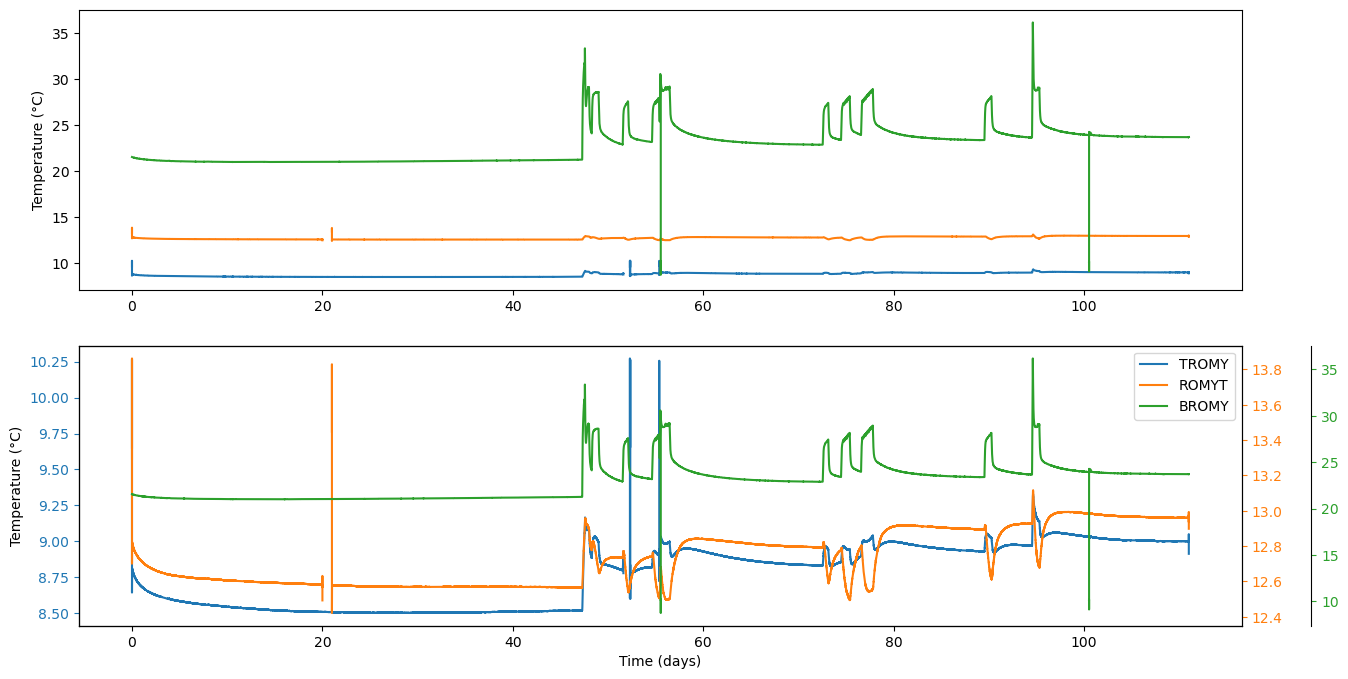

In [20]:
fig = __compare_temperature();

if config['save']:
    fig.savefig(config['path_to_figs']+"TILT_Huddle_all_temperatures.png", format="png", dpi=200, bbox_inches='tight')

## Correct for Linear Temperature Trend

In [18]:
TROMY.trim(config['tbeg'], config['tend']-10)

3 Trace(s) in Stream:
BW.TROMY..MAN | 2023-07-08T00:00:00.000000Z - 2023-10-26T23:59:50.000000Z | 1.0 Hz, 9590391 samples (masked)
BW.TROMY..MAE | 2023-07-07T23:59:59.999999Z - 2023-10-26T23:59:49.999999Z | 1.0 Hz, 9590391 samples (masked)
BW.TROMY..MAT | 2023-07-07T23:59:59.999999Z - 2023-10-26T23:59:49.999999Z | 1.0 Hz, 9590391 samples (masked)

In [19]:
def __correct_temperature_trend(st, correction):

    st0 = st.copy()
    temperature = st0.select(channel="*T")[0].data

#     st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
#     st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
    st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)

    return st0

In [20]:
## apply correction model
TROMY = __correct_temperature_trend(TROMY, temperature_correction['TROMY'])
ROMYT = __correct_temperature_trend(ROMYT, temperature_correction['ROMYT'])
BROMY = __correct_temperature_trend(BROMY, temperature_correction['BROMY'])

In [21]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= mean(tr.data[:500])

In [22]:
def __plot_all_tilt(st1, st2, st3):

    from datetime import datetime

    NN=3

    fig, ax = plt.subplots(NN,1, figsize=(15,8), sharex=True)

    font = 14

    tilt_scaling, tilt_unit = 1e-6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"

    ax[0].plot(st1.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*N")[0].data/tilt_scaling, label="TROMY")
    ax[0].plot(st2.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*N")[0].data/tilt_scaling, label="ROMYT")
    ax[0].plot(st3.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*N")[0].data/tilt_scaling, label="BROMY")

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st2.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st3.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*E")[0].data/tilt_scaling)

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*E")[0].data/tilt_scaling*-1, color="grey")

    ax[2].plot(st1.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st1.select(channel="*T")[0].data)
    ax[2].plot(st2.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st2.select(channel="*T")[0].data)
    ax[2].plot(st3.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling,
               st3.select(channel="*T")[0].data)

    ax[0].set_ylabel(f"N ({tilt_unit})", fontsize=font)
    ax[1].set_ylabel(f"E ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"T (°C)", fontsize=font)
#     ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font)

    for o in range(3):
        ax[o].grid()
        ax[o].set_ylim(-50, 50)

    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.7, 1.1), ncol=3, framealpha=1)

    tcks= ax[NN-1].get_xticks()
    tcklbls = [datetime.fromtimestamp(t*time_scaling+datetime(2019,1,1).timestamp()).strftime("%Y-%m-%d") for t in tcks]
    ax[NN-1].set_xticklabels(tcklbls)

    plt.show();
    # return fig

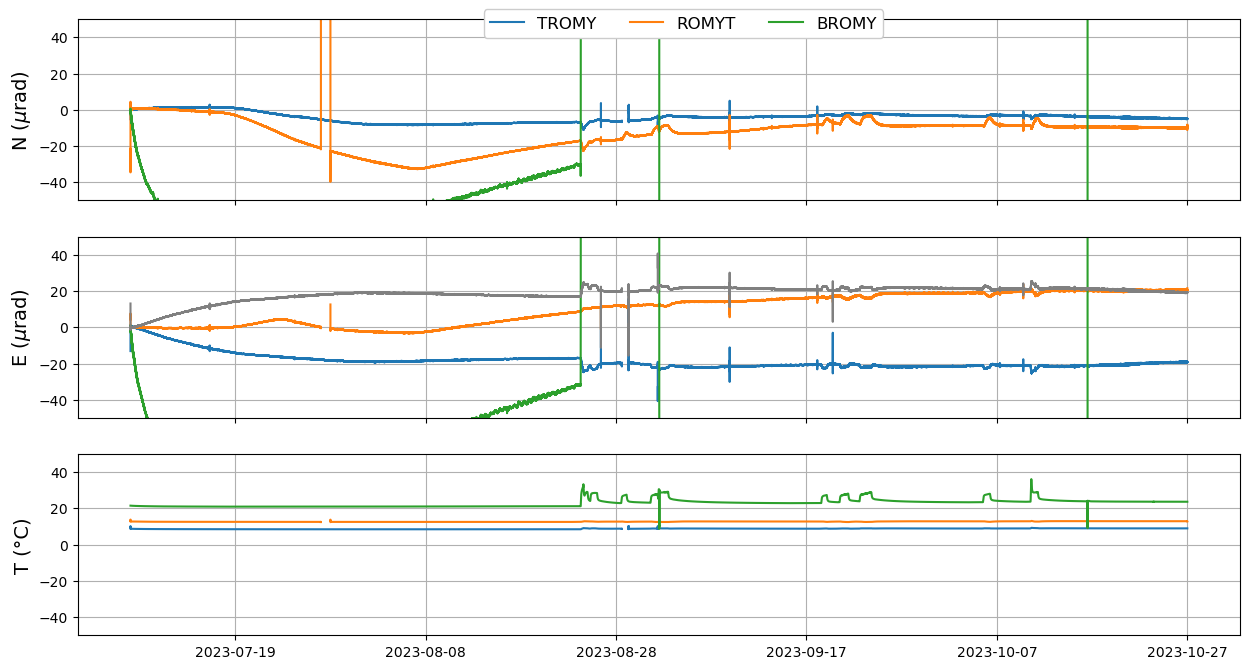

In [23]:
__plot_all_tilt(TROMY, ROMYT, BROMY);


## Add WROMY Data

In [ ]:
from andbro__load_WROMY_stream import __load_wromy_stream

In [ ]:
ws1 = __load_wromy_stream(config['path_to_wromy'], "BW.WROMY..WS1", config['tbeg'], config['tend'])

In [ ]:
from numpy import isfinite, array
import numpy.ma as ma

arr = ws1.select(channel="*T")[0].data
# arr = array([1,2,3,nan,3,4])
# mask = isfinite(arr)
# ma_arr = ma.masked_array(arr, mask=mask)

ma_arr = ma.masked_invalid(arr)
ws1.select(channel="*T")[0].data = ma.masked_invalid(arr)

plt.plot(ma_arr)

### Load FURT Data

In [ ]:
from andbro__load_FURT_stream import __load_furt_stream

In [ ]:
# furt = __load_furt_stream(config['tbeg'], config['tend'])

## Check effect of Lüftungsventil

In [ ]:
config['tbeg'] = "2023-01-01"

ws1 = __load_wromy_stream(config['path_to_wromy'], "BW.WROMY..WS1", config['tbeg'], config['tend'])

In [ ]:
ws1.select(channel="*T")[0].plot();

In [ ]:
config['tbeg'] = UTCDateTime("2023-01-01")

BROMY0 = __read_sds("/import/freenas-ffb-01-data/romy_archive/", "BW.DROMY..LA*", config['tbeg'], config['tend'])

BROMY0.sort()
BROMY0.merge()

In [ ]:
BROMY0 = __conversion_to_tilt(BROMY0, confTilt['BROMY'])

In [ ]:
tr = BROMY0.select(channel="*T")[0].trim(config['tbeg'], UTCDateTime("2023-06-15"))

plt.plot(tr.times(), tr.data)
plt.ylim(12, 13.5)